# Cyber Security Attacks Dataset Logistic Regression

### [Cyber Security Attacks Dataset](https://www.kaggle.com/datasets/teamincribo/cyber-security-attacks)

Author: [Kevin Thomas](mailto:ket189@pitt.edu)

## Citation

[1] Aashray Agur

[2] Uma Venugopal, https://www.kaggle.com/umavenugopal

## Import Modules

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve, auc

## Load Dataset

In [60]:
df = pd.read_csv('cybersecurity_attacks.csv')

## Perform Essential Exploration & Data Cleaning

#### Display the initial number of rows and columns.

In [61]:
df.shape

(40000, 25)

#### Display the initial variable names and their associated data types.

In [62]:
df.dtypes

Timestamp                  object
Source IP Address          object
Destination IP Address     object
Source Port                 int64
Destination Port            int64
Protocol                   object
Packet Length               int64
Packet Type                object
Traffic Type               object
Payload Data               object
Malware Indicators         object
Anomaly Scores            float64
Alerts/Warnings            object
Attack Type                object
Attack Signature           object
Action Taken               object
Severity Level             object
User Information           object
Device Information         object
Network Segment            object
Geo-location Data          object
Proxy Information          object
Firewall Logs              object
IDS/IPS Alerts             object
Log Source                 object
dtype: object

#### Create the target variable with a 1/0 flag when `Malware Indicators` equals `IoC Detected`.

In [63]:
df['Malware Event'] = np.where(df['Malware Indicators'].fillna('') == 'IoC Detected', 1, 0)

#### Display the number of missing values for each column, remove the missing values and create a clean copy of the dataset.

In [64]:
df.isna().sum()

Timestamp                     0
Source IP Address             0
Destination IP Address        0
Source Port                   0
Destination Port              0
Protocol                      0
Packet Length                 0
Packet Type                   0
Traffic Type                  0
Payload Data                  0
Malware Indicators        20000
Anomaly Scores                0
Alerts/Warnings           20067
Attack Type                   0
Attack Signature              0
Action Taken                  0
Severity Level                0
User Information              0
Device Information            0
Network Segment               0
Geo-location Data             0
Proxy Information         19851
Firewall Logs             19961
IDS/IPS Alerts            20050
Log Source                    0
Malware Event                 0
dtype: int64

In [65]:
df_clean = df.dropna(subset=[column for column in df.columns if column != 'Malware Indicators']).copy()

In [66]:
df_clean.isna().sum()

Timestamp                    0
Source IP Address            0
Destination IP Address       0
Source Port                  0
Destination Port             0
Protocol                     0
Packet Length                0
Packet Type                  0
Traffic Type                 0
Payload Data                 0
Malware Indicators        1214
Anomaly Scores               0
Alerts/Warnings              0
Attack Type                  0
Attack Signature             0
Action Taken                 0
Severity Level               0
User Information             0
Device Information           0
Network Segment              0
Geo-location Data            0
Proxy Information            0
Firewall Logs                0
IDS/IPS Alerts               0
Log Source                   0
Malware Event                0
dtype: int64

#### Display the number of unique values for each column after removing missing data and before initial exploration.

In [67]:
df_clean.nunique()

Timestamp                 2451
Source IP Address         2451
Destination IP Address    2451
Source Port               2402
Destination Port          2393
Protocol                     3
Packet Length             1148
Packet Type                  2
Traffic Type                 3
Payload Data              2451
Malware Indicators           1
Anomaly Scores            2159
Alerts/Warnings              1
Attack Type                  3
Attack Signature             2
Action Taken                 3
Severity Level               3
User Information          2418
Device Information        2240
Network Segment              3
Geo-location Data         2157
Proxy Information         2451
Firewall Logs                1
IDS/IPS Alerts               1
Log Source                   2
Malware Event                2
dtype: int64

#### Display the number of unique values for the categorical variables after removing missing data and before initial exploration.

In [68]:
df_clean.select_dtypes(exclude='number').nunique()

Timestamp                 2451
Source IP Address         2451
Destination IP Address    2451
Protocol                     3
Packet Type                  2
Traffic Type                 3
Payload Data              2451
Malware Indicators           1
Alerts/Warnings              1
Attack Type                  3
Attack Signature             2
Action Taken                 3
Severity Level               3
User Information          2418
Device Information        2240
Network Segment              3
Geo-location Data         2157
Proxy Information         2451
Firewall Logs                1
IDS/IPS Alerts               1
Log Source                   2
dtype: int64

#### Display the number of unique values for the continuous variables after removing missing data and before initial exploration.

In [69]:
df_clean.select_dtypes(include='number').nunique()

Source Port         2402
Destination Port    2393
Packet Length       1148
Anomaly Scores      2159
Malware Event          2
dtype: int64

## Functions

In [70]:
def my_coefplot(model, 
                figsize_use=(12, 8), 
                zero_nudge=9e-3):
    """
    Plot coefficient estimates and approximate 95% confidence intervals for a fitted statsmodels model.

    This function produces a horizontal errorbar plot of model coefficients where each parameter's
    point estimate is shown as a dot and an approximate 95% confidence interval is shown as a horizontal
    line of ±2 standard errors. A vertical dashed line at x=0 is added for visual reference of the
    null effect.

    Parameters
    ----------
    model : statsmodels regression results object
        A fitted statsmodels model result (for example, the object returned by `.fit()` on an
        OLS/Logit/GLM model). The object must expose the attributes:
          - params : pandas.Series or array-like of coefficient estimates (indexed by parameter name)
          - bse    : pandas.Series or array-like of standard errors for the estimates
        If these attributes are absent, the function raises a ValueError.
    figsize_use : tuple, optional
        Figure size (width, height) in inches for matplotlib. Default is (12, 8).
    zero_nudge : float, optional
        Amount to nudge significant coefficients away from zero for visual clarity. Default is 0.009.

    Returns
    -------
    None
        Displays the coefficient plot using matplotlib. The function does not return a value but
        will raise an error if the model does not provide the required attributes.

    Raises
    ------
    ValueError
        If the provided `model` does not have the required `params` and `bse` attributes or if
        their lengths/indexes are incompatible.
    """
    # Extract coefficient estimates from the model
    params = model.params

    # Extract 95% confidence intervals from the model
    conf_int = model.conf_int()
    lower = conf_int[0]
    upper = conf_int[1]

    # Determine which coefficients are significant (confidence interval does not include zero)
    sig = ~((lower < 0) & (upper > 0))

    # Create a matplotlib figure and axes
    _, ax = plt.subplots(figsize=figsize_use)

    # Iterate through coefficients and plot each with error bars
    for i, (p, l, u, s) in enumerate(zip(params, lower, upper, sig)):
        # If significant and coefficient is very close to zero, nudge it away for visibility
        plot_p = p
        plot_l = l
        plot_u = u
        if s and abs(p) < zero_nudge * 10:
            # Nudge away from zero for clarity
            plot_p = zero_nudge if p >= 0 else -zero_nudge
            plot_l = plot_p - abs(plot_p - l)
            plot_u = plot_p + abs(u - plot_p)
        
        # Plot the coefficient with error bars
        ax.errorbar(
            y=[params.index[i]],
            x=[plot_p],
            xerr=[[plot_p-plot_l], [plot_u-plot_p]],
            fmt='o',
            color='red' if s else 'black',
            ecolor='red' if s else 'black',
            elinewidth=2,
            ms=8
        )

    # Add a vertical dashed line at x=0 for reference
    ax.axvline(x=0, 
               linestyle='--', 
               linewidth=1.5, 
               color='grey')

    # Set x-axis label
    ax.set_xlabel('Coefficient Value')

    # Set y-axis ticks and labels to parameter names
    ax.set_yticks(range(len(params)))
    ax.set_yticklabels(params.index)

    # Add grid lines for easier reading
    ax.grid(axis='x', 
            linestyle=':', 
            alpha=0.6)

    # Adjust layout for better appearance
    plt.tight_layout()

    # Display the plot
    plt.show()

In [71]:
def train_and_test_logistic_with_cv(model_name,
                                    a_formula,
                                    df,
                                    input_names,
                                    output_name,
                                    cv,
                                    threshold: float=0.5):
    """
    Fit a statsmodels logistic regression inside cross-validation folds, compute
    classification predictions and per-fold accuracies for training and testing sets,
    and return a combined results DataFrame summarizing fold metrics and model info.

    This function performs the following steps for each fold produced by `cv.split(...)`:
      1. Partition the input DataFrame into a training fold and a test fold.
      2. Fit a StandardScaler on numeric predictors using only the training fold.
      3. Transform both training and test numeric predictors using that scaler (no refit
         on test data — avoids data leakage).
      4. Fit a statsmodels Logit model using the provided formula on the scaled training fold.
      5. Predict probabilities on both train and test folds, convert to class labels
         using the provided threshold, and compute accuracy for each fold/set.
      6. Aggregate per-fold accuracies into a single DataFrame with meta information.

    Parameters
    ----------
    model_name : str
        Human-readable model identifier used in the output DataFrame (e.g., "model_5").
    a_formula : str
        Patsy-style formula string accepted by statsmodels (e.g.,
        'Q("Malware Event") ~ Q("Source Port") + I(Q("Source Port") ** 2)').
        The formula is evaluated on the training fold when fitting the model.
    df : pandas.DataFrame
        The full dataset containing both features and the target column.
        The function will not modify the caller's DataFrame (it uses copies).
    input_names : list[str]
        List of column names in df that comprise the predictor set.
        Numeric columns in this list will be scaled per-fold. Non-numeric columns
        (e.g., categorical features referenced with C(...) in the formula) are left unchanged.
    output_name : str
        Column name for the binary target variable contained in df.
        The CV split uses df[output_name] for stratification if cv supports it.
    cv : object
        Cross-validation splitter object implementing split(X, y) (e.g., sklearn.model_selection.StratifiedKFold).
        It must yield pairs of (train_index, test_index).
    threshold : float, optional (default=0.5)
        Probability threshold for mapping predicted probabilities to class labels:
        predicted_class = 1 if predicted_prob > threshold else 0.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with columns:
          - Accuracy: accuracy score for the fold and set
          - from_set: 'training' or 'testing'
          - fold_id: 1-indexed fold identifier
          - model_name: same as model_name
          - model_formula: the formula string used
          - num_coefs: number of coefficients in the fitted statsmodels model
          - threshold: threshold used for classification
        The DataFrame contains one row per fold per set (2 * n_splits rows).
    """
    # Validate inputs early
    if output_name not in df.columns:
        raise ValueError(f'target column "{output_name}" not found in df')
    missing_x = [column for column in input_names if column not in df.columns]
    if missing_x:
        raise ValueError(f'predictor columns not found in df: {missing_x}')

    # Separate the inputs and output (not used directly for splitting but used to detect types)
    input_df = df.loc[:, input_names].copy()

    # Detect numeric columns once (you could also pass these in)
    numeric_cols = [column for column in input_names if pd.api.types.is_numeric_dtype(df[column].dtype)]

    # Initialize the performance metric storage lists
    train_res = []
    test_res = []
    a_mod = None  # Last fitted model (kept for metrics like num_coefs)

    # Split the data and iterate over the folds
    for train_id, test_id in cv.split(input_df.to_numpy(), df[output_name].to_numpy()):
        # Subset the training and test splits within each fold
        train_data = df.iloc[train_id, :].copy()
        test_data = df.iloc[test_id, :].copy()

        # --- Scale numeric features: fit on train, transform train & test ---
        if numeric_cols:
            # Cast per-fold numeric columns to float64 and assign back (forces dtype update)
            train_data[numeric_cols] = train_data[numeric_cols].astype('float64')
            test_data[numeric_cols] = test_data[numeric_cols].astype('float64')

            # Initialize the scaler and fit it on the training data
            scaler = StandardScaler()
            scaler.fit(train_data[numeric_cols])

            # Transform the training data
            train_scaled = pd.DataFrame(
                scaler.transform(train_data[numeric_cols]),
                index=train_data.index,
                columns=numeric_cols,
                dtype='float64'
            )
            test_scaled = pd.DataFrame(
                scaler.transform(test_data[numeric_cols]),
                index=test_data.index,
                columns=numeric_cols,
                dtype='float64'
            )

            # Assign back column-by-column, but now guaranteed float64
            for col in numeric_cols:
                train_data[col] = train_scaled[col].to_numpy(dtype='float64')
                test_data[col] = test_scaled[col].to_numpy(dtype='float64')
        # -------------------------------------------------------------------

        # Fit the model on the training data within the current fold
        a_mod = smf.logit(formula=a_formula, data=train_data).fit(disp=0)

        # Predict the training within each fold
        train_copy = train_data.copy()
        train_copy['pred_probability'] = a_mod.predict(train_data)
        train_copy['pred_class'] = np.where(train_copy['pred_probability'] > threshold, 1, 0)

        # Predict the testing within each fold
        test_copy = test_data.copy()
        test_copy['pred_probability'] = a_mod.predict(test_data)
        test_copy['pred_class'] = np.where(test_copy['pred_probability'] > threshold, 1, 0)

        # Calculate the performance metric on the training set within the fold
        train_res.append(np.mean(train_copy[output_name] == train_copy['pred_class']))

        # Calculate the performance metric on the testing set within the fold
        test_res.append(np.mean(test_copy[output_name] == test_copy['pred_class']))

    # Book keeping to store the results
    train_df = pd.DataFrame({'Accuracy': train_res})
    train_df['from_set'] = 'training'
    train_df['fold_id'] = train_df.index + 1
    test_df = pd.DataFrame({'Accuracy': test_res})
    test_df['from_set'] = 'testing'
    test_df['fold_id'] = test_df.index + 1

    # Combine the splits together
    res_df = pd.concat([train_df, test_df], ignore_index=True)

    # Add information about the model
    res_df['model_name'] = model_name
    res_df['model_formula'] = a_formula
    res_df['num_coefs'] = len(a_mod.params) if a_mod is not None else 0
    res_df['threshold'] = threshold

    # Return the results DataFrame
    return res_df

## Formulas

In [72]:
df_clean.dtypes

Timestamp                  object
Source IP Address          object
Destination IP Address     object
Source Port                 int64
Destination Port            int64
Protocol                   object
Packet Length               int64
Packet Type                object
Traffic Type               object
Payload Data               object
Malware Indicators         object
Anomaly Scores            float64
Alerts/Warnings            object
Attack Type                object
Attack Signature           object
Action Taken               object
Severity Level             object
User Information           object
Device Information         object
Network Segment            object
Geo-location Data          object
Proxy Information          object
Firewall Logs              object
IDS/IPS Alerts             object
Log Source                 object
Malware Event               int64
dtype: object

In [73]:
formula_list = [
    # Model 00: Intercept-Only or Constant Average
    'Q("Malware Event") ~ 1',

    # Model 01: Categorical Inputs w/ Additive Features
    'Q("Malware Event") ~ C(Q("Protocol")) + C(Q("Packet Type")) + C(Q("Traffic Type")) + C(Q("Alerts/Warnings")) + C(Q("Attack Type")) + C(Q("Attack Signature")) + C(Q("Action Taken")) + C(Q("Severity Level")) + C(Q("Network Segment")) + C(Q("Firewall Logs")) + C(Q("IDS/IPS Alerts")) + C(Q("Log Source"))',

    # Model 02: Continuous Inputs w/ Linear Additive Features
    'Q("Malware Event") ~ Q("Source Port") + Q("Destination Port") + Q("Packet Length") + Q("Anomaly Scores")',

    # Model 03: All Inputs w/ Linear Additive Features
    'Q("Malware Event") ~ Q("Source Port") + Q("Destination Port") + Q("Packet Length") + Q("Anomaly Scores") + C(Q("Protocol")) + C(Q("Packet Type")) + C(Q("Traffic Type")) + C(Q("Alerts/Warnings")) + C(Q("Attack Type")) + C(Q("Attack Signature")) + C(Q("Action Taken")) + C(Q("Severity Level")) + C(Q("Network Segment")) + C(Q("Firewall Logs")) + C(Q("IDS/IPS Alerts")) + C(Q("Log Source"))',

    # Model 04: Continuous Inputs w/ Linear Main Effect & Pair-Wise Interactions Quadratic
    'Q("Malware Event") ~ Q("Source Port") + Q("Destination Port") + Q("Packet Length") + Q("Anomaly Scores") + Q("Source Port"):Q("Destination Port") + Q("Source Port"):Q("Packet Length") + Q("Source Port"):Q("Anomaly Scores") + Q("Destination Port"):Q("Packet Length") + Q("Destination Port"):Q("Anomaly Scores") + Q("Packet Length"):Q("Anomaly Scores") + np.power(Q("Source Port"), 2) + np.power(Q("Destination Port"), 2) + np.power(Q("Packet Length"), 2) + np.power(Q("Anomaly Scores"), 2)',

    # Model 05: Interact Categorical Inputs w/ Continuous Inputs
    'Q("Malware Event") ~ Q("Source Port") + Q("Destination Port") + Q("Packet Length") + Q("Anomaly Scores") + C(Q("Protocol")) + C(Q("Packet Type")) + C(Q("Traffic Type")) + C(Q("Alerts/Warnings")) + C(Q("Attack Type")) + C(Q("Attack Signature")) + C(Q("Action Taken")) + C(Q("Severity Level")) + C(Q("Network Segment")) + C(Q("Firewall Logs")) + C(Q("IDS/IPS Alerts")) + C(Q("Log Source")) + Q("Source Port"):Q("Destination Port") + Q("Source Port"):Q("Packet Length") + Q("Source Port"):Q("Anomaly Scores") + Q("Destination Port"):Q("Packet Length") + Q("Destination Port"):Q("Anomaly Scores") + Q("Packet Length"):Q("Anomaly Scores")',

    # Model 06: Continuous Inputs w/ Linear Main Effect & Pair-Wise Interactions Cubic
    'Q("Malware Event") ~ Q("Source Port") + Q("Destination Port") + Q("Packet Length") + Q("Anomaly Scores") + Q("Source Port"):Q("Destination Port") + Q("Source Port"):Q("Packet Length") + Q("Source Port"):Q("Anomaly Scores") + Q("Destination Port"):Q("Packet Length") + Q("Destination Port"):Q("Anomaly Scores") + Q("Packet Length"):Q("Anomaly Scores") + np.power(Q("Source Port"), 2) + np.power(Q("Destination Port"), 2) + np.power(Q("Packet Length"), 2) + np.power(Q("Anomaly Scores"), 2) + np.power(Q("Source Port"), 3) + np.power(Q("Destination Port"), 3) + np.power(Q("Packet Length"), 3) + np.power(Q("Anomaly Scores"), 3)',

    # Model 07: Continuous Inputs w/ Linear Main Effect & Pair-Wise Interactions Quartic
    'Q("Malware Event") ~ Q("Source Port") + Q("Destination Port") + Q("Packet Length") + Q("Anomaly Scores") + Q("Source Port"):Q("Destination Port") + Q("Source Port"):Q("Packet Length") + Q("Source Port"):Q("Anomaly Scores") + Q("Destination Port"):Q("Packet Length") + Q("Destination Port"):Q("Anomaly Scores") + Q("Packet Length"):Q("Anomaly Scores") + np.power(Q("Source Port"), 2) + np.power(Q("Destination Port"), 2) + np.power(Q("Packet Length"), 2) + np.power(Q("Anomaly Scores"), 2) + np.power(Q("Source Port"), 3) + np.power(Q("Destination Port"), 3) + np.power(Q("Packet Length"), 3) + np.power(Q("Anomaly Scores"), 3) + np.power(Q("Source Port"), 4) + np.power(Q("Destination Port"), 4) + np.power(Q("Packet Length"), 4) + np.power(Q("Anomaly Scores"), 4)',

    # Model 08: Pairwise Interactions Among Key Categorical Features
    'Q("Malware Event") ~ C(Q("Protocol")) * C(Q("Packet Type")) + C(Q("Traffic Type")) * C(Q("Attack Type")) + C(Q("Severity Level")) + C(Q("Action Taken")) + C(Q("Log Source"))'
]

## Fit Models

### Model 00: Intercept-Only or Constant Average

In [74]:
model_00 = smf.logit(formula=formula_list[0], 
                     data=df_clean). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.693103
         Iterations 3


In [75]:
model_00.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Q("Malware Event")   No. Observations:                 2451
Model:                          Logit   Df Residuals:                     2450
Method:                           MLE   Df Model:                            0
Date:                Sat, 30 Aug 2025   Pseudo R-squ.:               6.106e-11
Time:                        11:07:14   Log-Likelihood:                -1698.8
converged:                       True   LL-Null:                       -1698.8
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0188      0.040      0.465      0.642      -0.060       0.098
==============================================================================
"""

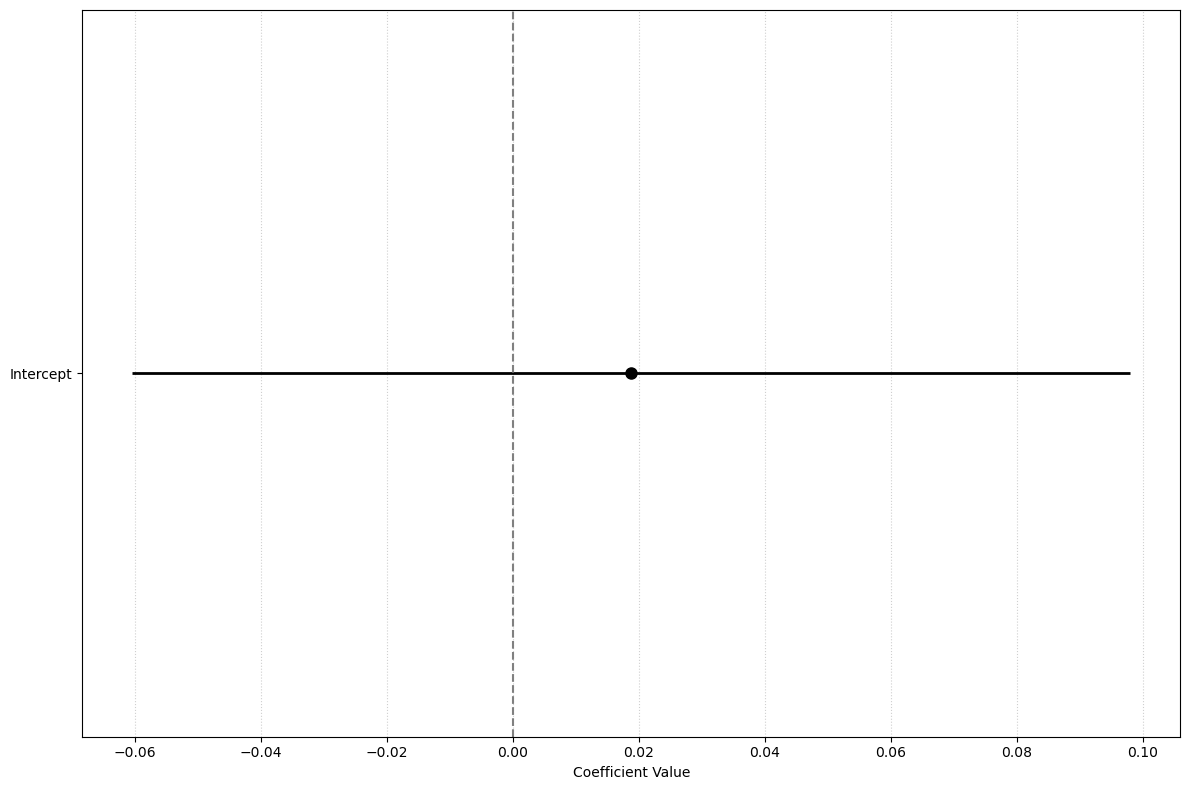

In [76]:
my_coefplot(model_00)

### Model 01: Categorical Inputs w/ Additive Features

In [77]:
model_01 = smf.logit(formula=formula_list[1], 
                     data=df_clean). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.688893
         Iterations 4


In [78]:
model_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Q("Malware Event")   No. Observations:                 2451
Model:                          Logit   Df Residuals:                     2435
Method:                           MLE   Df Model:                           15
Date:                Sat, 30 Aug 2025   Pseudo R-squ.:                0.006074
Time:                        11:07:14   Log-Likelihood:                -1688.5
converged:                       True   LL-Null:                       -1698.8
Covariance Type:            nonrobust   LLR p-value:                    0.1489
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.1275      0.163      0.783      0.434      -0.192       0.447
C(Q("Protocol"))[T.TCP]                        -0.1494      0.100     -1.493      0.135      -0.346       0.047
C(Q("Protocol"))[T.UDP]                        -0.0507      0.099     -0.510      0.610      -0.246       0.144
C(Q("Packet Type"))[T.Data]                     0.0702      0.081      0.862      0.389      -0.089       0.230
C(Q("Traffic Type"))[T.FTP]                    -0.2257      0.101     -2.242      0.025      -0.423      -0.028
C(Q("Traffic Type"))[T.HTTP]                   -0.3355      0.100     -3.345      0.001      -0.532      -0.139
C(Q("Attack Type"))[T.Intrusion]                0.1033      0.100      1.034      0.301      -0.092       0.299
C(Q("Attack Type"))[T.Malware]                  0.0168      0.099      0.169      0.866      -0.178       0.211
C(Q("Attack Signature"))[T.Known Pattern B]     0.0514      0.081      0.633      0.527      -0.108       0.211
C(Q("Action Taken"))[T.Ignored]                 0.1030      0.099      1.039      0.299      -0.091       0.297
C(Q("Action Taken"))[T.Logged]                  0.0512      0.099      0.516      0.606      -0.143       0.245
C(Q("Severity Level"))[T.Low]                  -0.0165      0.100     -0.166      0.868      -0.212       0.179
C(Q("Severity Level"))[T.Medium]               -0.0694      0.098     -0.705      0.481      -0.262       0.123
C(Q("Network Segment"))[T.Segment B]            0.0957      0.100      0.959      0.338      -0.100       0.291
C(Q("Network Segment"))[T.Segment C]           -0.0737      0.100     -0.738      0.461      -0.270       0.122
C(Q("Log Source"))[T.Server]                    0.0435      0.081      0.535      0.593      -0.116       0.203
===============================================================================================================
"""

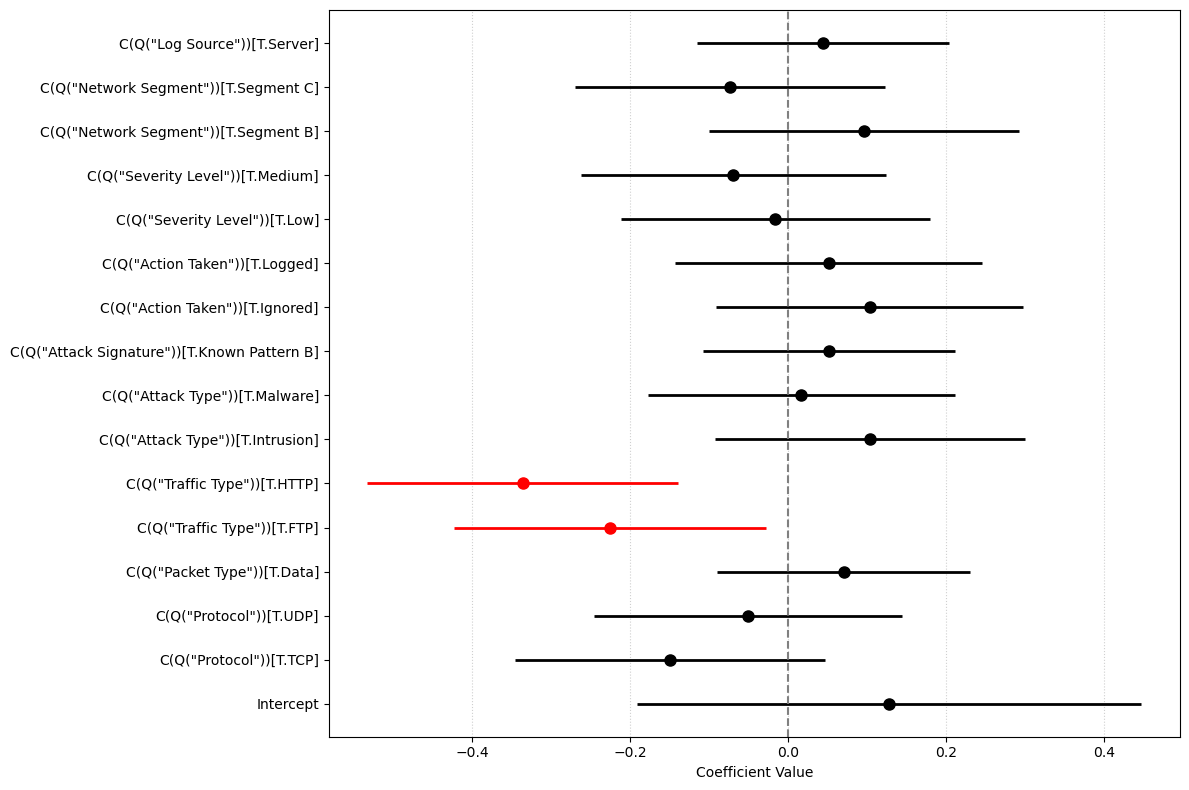

In [79]:
my_coefplot(model_01)

### Model 02: Continuous Inputs w/ Linear Additive Features

In [80]:
model_02 = smf.logit(formula=formula_list[2], 
                     data=df_clean). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.692796
         Iterations 3


In [81]:
model_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Q("Malware Event")   No. Observations:                 2451
Model:                          Logit   Df Residuals:                     2446
Method:                           MLE   Df Model:                            4
Date:                Sat, 30 Aug 2025   Pseudo R-squ.:               0.0004430
Time:                        11:07:14   Log-Likelihood:                -1698.0
converged:                       True   LL-Null:                       -1698.8
Covariance Type:            nonrobust   LLR p-value:                    0.8257
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.1288      0.148     -0.868      0.385      -0.420       0.162
Q("Source Port")       2.029e-06   2.16e-06      0.940      0.347    -2.2e-06    6.26e-06
Q("Destination Port")  1.555e-06   2.19e-06      0.711      0.477   -2.73e-06    5.84e-06
Q("Packet Length")     8.177e-06   9.74e-05      0.084      0.933      -0.000       0.000
Q("Anomaly Scores")       0.0004      0.001      0.309      0.757      -0.002       0.003
=========================================================================================
"""

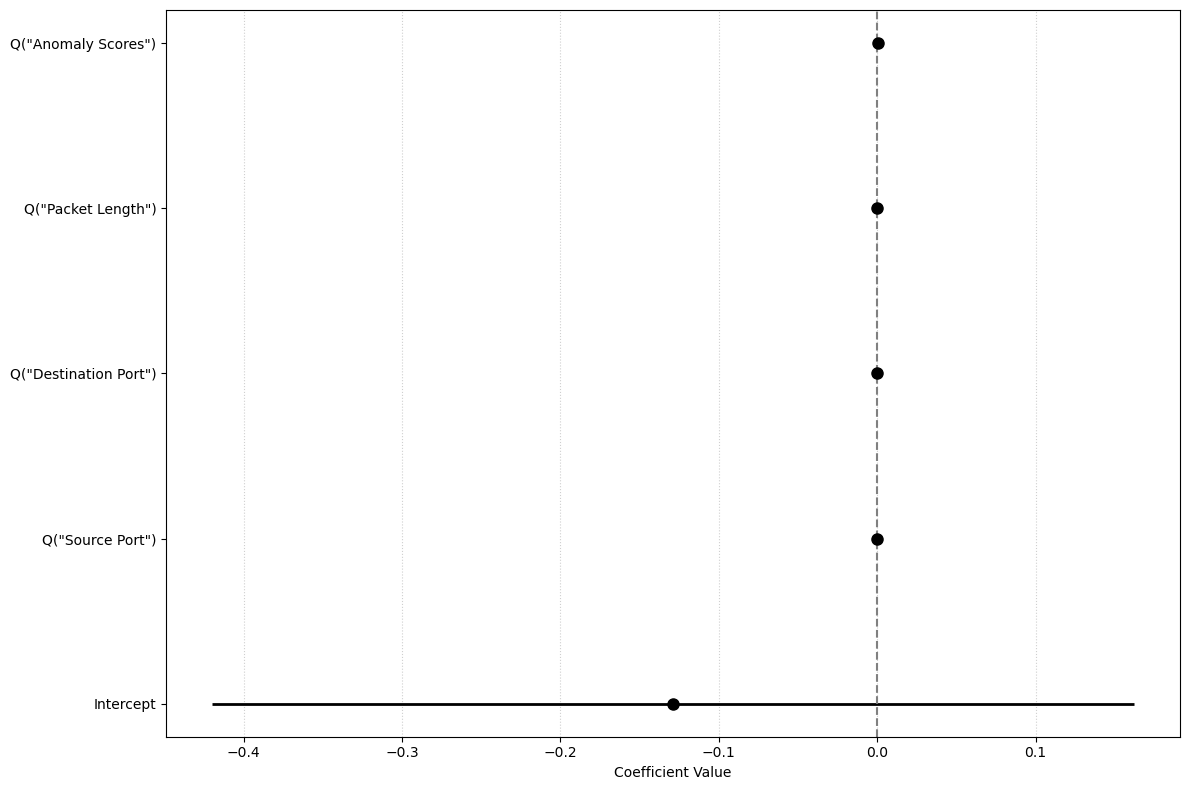

In [82]:
my_coefplot(model_02)

### Model 03: All Inputs w/ Linear Additive Features

In [83]:
model_03 = smf.logit(formula=formula_list[3], 
                     data=df_clean). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.688563
         Iterations 4


In [84]:
model_03.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Q("Malware Event")   No. Observations:                 2451
Model:                          Logit   Df Residuals:                     2431
Method:                           MLE   Df Model:                           19
Date:                Sat, 30 Aug 2025   Pseudo R-squ.:                0.006551
Time:                        11:07:14   Log-Likelihood:                -1687.7
converged:                       True   LL-Null:                       -1698.8
Covariance Type:            nonrobust   LLR p-value:                    0.2716
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -0.0376      0.220     -0.171      0.864      -0.468       0.393
C(Q("Protocol"))[T.TCP]                        -0.1442      0.100     -1.438      0.150      -0.341       0.052
C(Q("Protocol"))[T.UDP]                        -0.0484      0.100     -0.486      0.627      -0.244       0.147
C(Q("Packet Type"))[T.Data]                     0.0708      0.081      0.869      0.385      -0.089       0.231
C(Q("Traffic Type"))[T.FTP]                    -0.2256      0.101     -2.239      0.025      -0.423      -0.028
C(Q("Traffic Type"))[T.HTTP]                   -0.3370      0.100     -3.357      0.001      -0.534      -0.140
C(Q("Attack Type"))[T.Intrusion]                0.1046      0.100      1.045      0.296      -0.091       0.301
C(Q("Attack Type"))[T.Malware]                  0.0209      0.099      0.210      0.834      -0.174       0.216
C(Q("Attack Signature"))[T.Known Pattern B]     0.0551      0.081      0.677      0.498      -0.104       0.215
C(Q("Action Taken"))[T.Ignored]                 0.1034      0.099      1.043      0.297      -0.091       0.298
C(Q("Action Taken"))[T.Logged]                  0.0530      0.099      0.535      0.593      -0.141       0.247
C(Q("Severity Level"))[T.Low]                  -0.0168      0.100     -0.169      0.866      -0.212       0.179
C(Q("Severity Level"))[T.Medium]               -0.0719      0.099     -0.730      0.465      -0.265       0.121
C(Q("Network Segment"))[T.Segment B]            0.0962      0.100      0.963      0.336      -0.100       0.292
C(Q("Network Segment"))[T.Segment C]           -0.0756      0.100     -0.756      0.450      -0.272       0.120
C(Q("Log Source"))[T.Server]                    0.0435      0.081      0.535      0.593      -0.116       0.203
Q("Source Port")                             2.021e-06   2.17e-06      0.931      0.352   -2.24e-06    6.28e-06
Q("Destination Port")                        1.609e-06    2.2e-06      0.731      0.465   -2.71e-06    5.92e-06
Q("Packet Length")                           9.125e-06    9.8e-05      0.093      0.926      -0.000       0.000
Q("Anomaly Scores")                             0.0006      0.001      0.447      0.655      -0.002       0.003
===============================================================================================================
"""

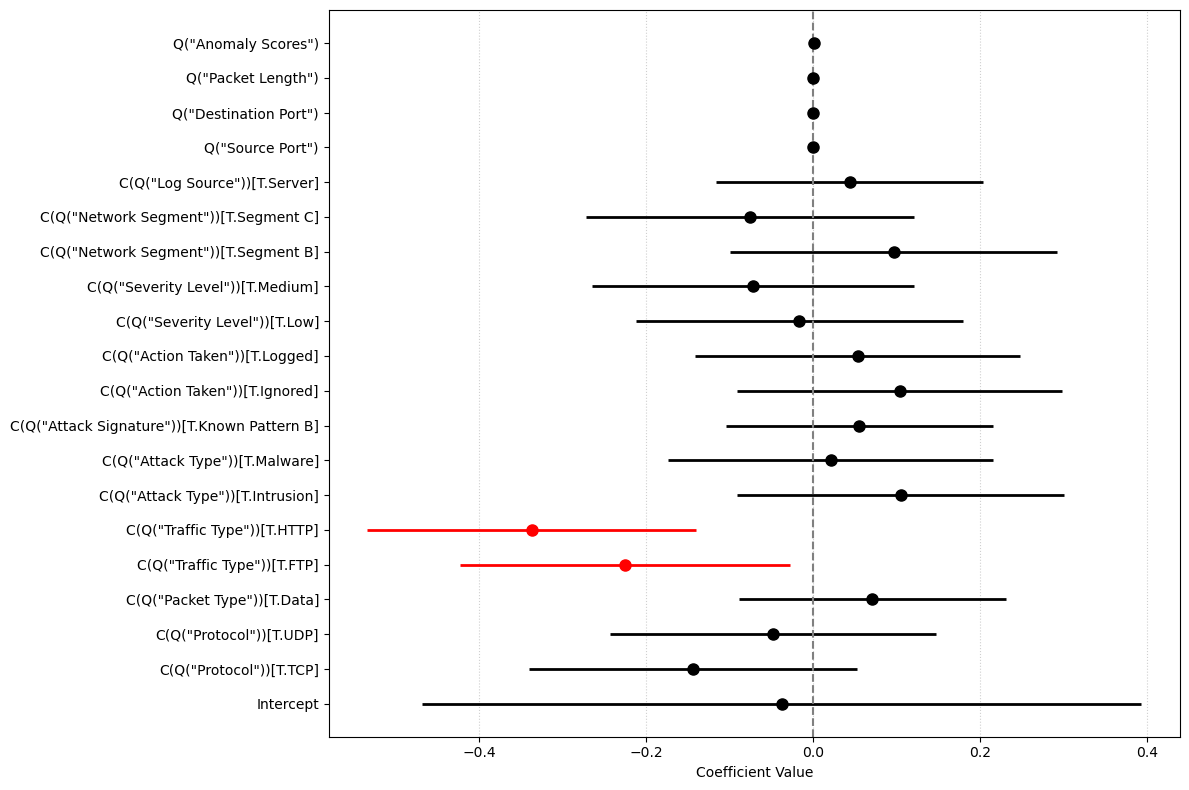

In [85]:
my_coefplot(model_03)

### Model 04: Continuous Inputs w/ Linear Main Effect & Pair-Wise Interactions Quadratic

In [86]:
model_04 = smf.logit(formula=formula_list[4], 
                     data=df_clean). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.691038
         Iterations 4


In [87]:
model_04.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Q("Malware Event")   No. Observations:                 2451
Model:                          Logit   Df Residuals:                     2436
Method:                           MLE   Df Model:                           14
Date:                Sat, 30 Aug 2025   Pseudo R-squ.:                0.002980
Time:                        11:07:15   Log-Likelihood:                -1693.7
converged:                       True   LL-Null:                       -1698.8
Covariance Type:            nonrobust   LLR p-value:                    0.7530
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.1324      0.401      0.330      0.741      -0.653       0.918
Q("Source Port")                          -4.898e-06   1.11e-05     -0.441      0.660   -2.67e-05    1.69e-05
Q("Destination Port")                     -1.359e-05   1.13e-05     -1.201      0.230   -3.58e-05    8.59e-06
Q("Packet Length")                           -0.0002      0.001     -0.439      0.661      -0.001       0.001
Q("Anomaly Scores")                           0.0064      0.007      0.906      0.365      -0.007       0.020
Q("Source Port"):Q("Destination Port")      2.03e-10   1.18e-10      1.719      0.086   -2.85e-11    4.34e-10
Q("Source Port"):Q("Packet Length")        9.534e-10    5.2e-09      0.183      0.854   -9.23e-09    1.11e-08
Q("Source Port"):Q("Anomaly Scores")       2.329e-09   7.53e-08      0.031      0.975   -1.45e-07     1.5e-07
Q("Destination Port"):Q("Packet Length")   6.436e-10   5.24e-09      0.123      0.902   -9.63e-09    1.09e-08
Q("Destination Port"):Q("Anomaly Scores")  5.734e-08   7.64e-08      0.750      0.453   -9.24e-08    2.07e-07
Q("Packet Length"):Q("Anomaly Scores")    -5.832e-06   3.39e-06     -1.722      0.085   -1.25e-05    8.07e-07
np.power(Q("Source Port"), 2)             -6.757e-12   1.32e-10     -0.051      0.959   -2.66e-10    2.52e-10
np.power(Q("Destination Port"), 2)         7.477e-11   1.32e-10      0.566      0.572   -1.84e-10    3.34e-10
np.power(Q("Packet Length"), 2)            3.021e-07   2.68e-07      1.128      0.259   -2.23e-07    8.27e-07
np.power(Q("Anomaly Scores"), 2)          -3.349e-05    5.4e-05     -0.620      0.535      -0.000    7.24e-05
=============================================================================================================
"""

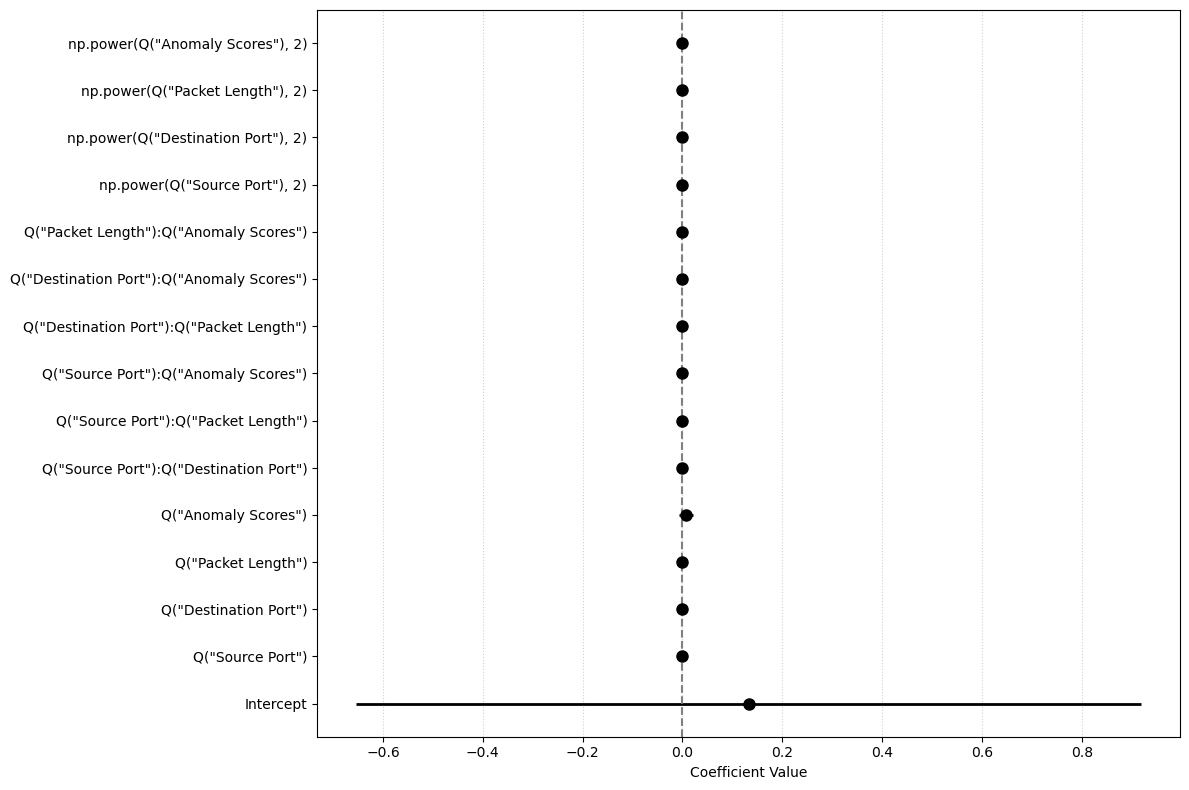

In [88]:
my_coefplot(model_04)

### Model 05: Interact Categorical Inputs w/ Continuous Inputs

In [89]:
model_05 = smf.logit(formula=formula_list[5], 
                     data=df_clean). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.687260
         Iterations 4


In [90]:
model_05.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Q("Malware Event")   No. Observations:                 2451
Model:                          Logit   Df Residuals:                     2425
Method:                           MLE   Df Model:                           25
Date:                Sat, 30 Aug 2025   Pseudo R-squ.:                0.008431
Time:                        11:07:15   Log-Likelihood:                -1684.5
converged:                       True   LL-Null:                       -1698.8
Covariance Type:            nonrobust   LLR p-value:                    0.2791
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.0663      0.383      0.173      0.863      -0.685       0.817
C(Q("Protocol"))[T.TCP]                        -0.1485      0.101     -1.476      0.140      -0.346       0.049
C(Q("Protocol"))[T.UDP]                        -0.0517      0.100     -0.518      0.604      -0.247       0.144
C(Q("Packet Type"))[T.Data]                     0.0630      0.082      0.771      0.441      -0.097       0.223
C(Q("Traffic Type"))[T.FTP]                    -0.2262      0.101     -2.235      0.025      -0.425      -0.028
C(Q("Traffic Type"))[T.HTTP]                   -0.3350      0.101     -3.324      0.001      -0.533      -0.138
C(Q("Attack Type"))[T.Intrusion]                0.1009      0.100      1.006      0.314      -0.096       0.297
C(Q("Attack Type"))[T.Malware]                  0.0282      0.100      0.283      0.777      -0.167       0.224
C(Q("Attack Signature"))[T.Known Pattern B]     0.0537      0.082      0.659      0.510      -0.106       0.214
C(Q("Action Taken"))[T.Ignored]                 0.1006      0.099      1.013      0.311      -0.094       0.295
C(Q("Action Taken"))[T.Logged]                  0.0562      0.099      0.565      0.572      -0.139       0.251
C(Q("Severity Level"))[T.Low]                  -0.0161      0.100     -0.160      0.872      -0.212       0.180
C(Q("Severity Level"))[T.Medium]               -0.0680      0.099     -0.689      0.491      -0.261       0.125
C(Q("Network Segment"))[T.Segment B]            0.1012      0.100      1.011      0.312      -0.095       0.297
C(Q("Network Segment"))[T.Segment C]           -0.0772      0.100     -0.770      0.441      -0.274       0.119
C(Q("Log Source"))[T.Server]                    0.0480      0.082      0.588      0.556      -0.112       0.208
Q("Source Port")                            -4.223e-06   7.05e-06     -0.599      0.549    -1.8e-05     9.6e-06
Q("Destination Port")                       -8.756e-06   7.22e-06     -1.213      0.225   -2.29e-05    5.39e-06
Q("Packet Length")                              0.0003      0.000      0.809      0.418      -0.000       0.001
Q("Anomaly Scores")                             0.0035      0.005      0.772      0.440      -0.005       0.012
Q("Source Port"):Q("Destination Port")       1.884e-10   1.19e-10      1.585      0.113   -4.46e-11    4.21e-10
Q("Source Port"):Q("Packet Length")          3.201e-10   5.24e-09      0.061      0.951   -9.94e-09    1.06e-08
Q("Source Port"):Q("Anomaly Scores")        -1.489e-09   7.58e-08     -0.020      0.984    -1.5e-07    1.47e-07
Q("Destination Port"):Q("Packet Length")     1.489e-09   5.28e-09      0.282      0.778   -8.87e-09    1.18e-08
Q("Destination Port"):Q("Anomaly Scores")    5.809e-08   7.69e-08      0.756      0.450   -9.26e-08    2.09e-07
Q("Packet Length"):Q("Anomaly Scores")      -6.025e-06   3.41e-06     -1.768      0.077   -1.27e-05    6.

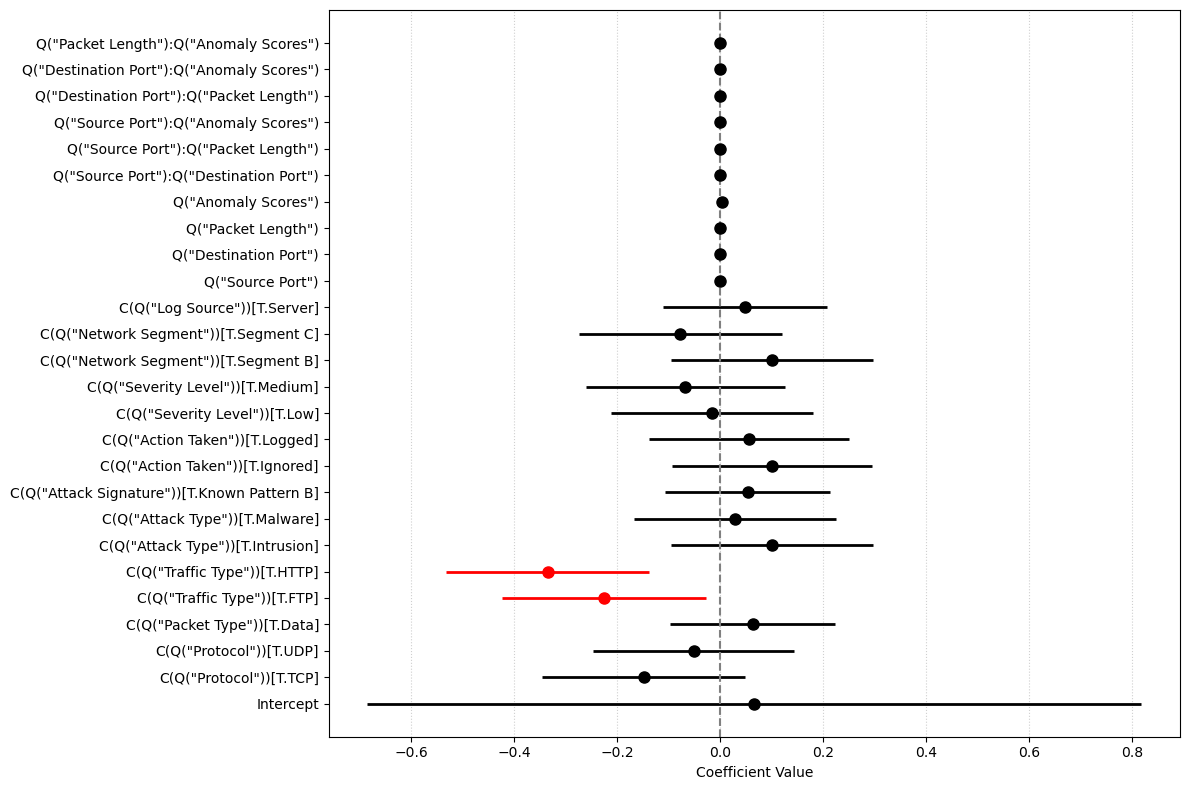

In [91]:
my_coefplot(model_05)

### Model 06: Continuous Inputs w/ Linear Main Effect & Pair-Wise Interactions Cubic

In [92]:
model_06 = smf.logit(formula=formula_list[6], 
                     data=df_clean). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.690167
         Iterations 4


In [93]:
model_06.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Q("Malware Event")   No. Observations:                 2451
Model:                          Logit   Df Residuals:                     2432
Method:                           MLE   Df Model:                           18
Date:                Sat, 30 Aug 2025   Pseudo R-squ.:                0.004236
Time:                        11:07:15   Log-Likelihood:                -1691.6
converged:                       True   LL-Null:                       -1698.8
Covariance Type:            nonrobust   LLR p-value:                    0.7033
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.1736      0.485      0.358      0.720      -0.777       1.124
Q("Source Port")                          -4.133e-05   2.41e-05     -1.716      0.086   -8.85e-05    5.87e-06
Q("Destination Port")                     -2.349e-05   2.46e-05     -0.955      0.340   -7.17e-05    2.47e-05
Q("Packet Length")                            0.0005      0.001      0.393      0.694      -0.002       0.003
Q("Anomaly Scores")                           0.0183      0.015      1.254      0.210      -0.010       0.047
Q("Source Port"):Q("Destination Port")     1.929e-10   1.18e-10      1.628      0.104   -3.94e-11    4.25e-10
Q("Source Port"):Q("Packet Length")        6.587e-10   5.21e-09      0.127      0.899   -9.54e-09    1.09e-08
Q("Source Port"):Q("Anomaly Scores")      -1.829e-09   7.54e-08     -0.024      0.981    -1.5e-07    1.46e-07
Q("Destination Port"):Q("Packet Length")   7.013e-10   5.25e-09      0.133      0.894    -9.6e-09     1.1e-08
Q("Destination Port"):Q("Anomaly Scores")  5.335e-08   7.66e-08      0.697      0.486   -9.67e-08    2.03e-07
Q("Packet Length"):Q("Anomaly Scores")    -6.175e-06    3.4e-06     -1.819      0.069   -1.28e-05     4.8e-07
np.power(Q("Source Port"), 2)              1.354e-09   8.13e-10      1.665      0.096   -2.39e-10    2.95e-09
np.power(Q("Destination Port"), 2)          4.53e-10   8.19e-10      0.553      0.580   -1.15e-09    2.06e-09
np.power(Q("Packet Length"), 2)            -7.56e-07   1.75e-06     -0.433      0.665   -4.18e-06    2.67e-06
np.power(Q("Anomaly Scores"), 2)             -0.0003      0.000     -0.982      0.326      -0.001       0.000
np.power(Q("Source Port"), 3)             -1.353e-14      8e-15     -1.691      0.091   -2.92e-14    2.15e-15
np.power(Q("Destination Port"), 3)        -3.734e-15   8.14e-15     -0.459      0.646   -1.97e-14    1.22e-14
np.power(Q("Packet Length"), 3)            4.482e-10   7.32e-10      0.612      0.541   -9.87e-10    1.88e-09
np.power(Q("Anomaly Scores"), 3)           1.936e-06   2.17e-06      0.894      0.371   -2.31e-06    6.18e-06
=============================================================================================================
"""

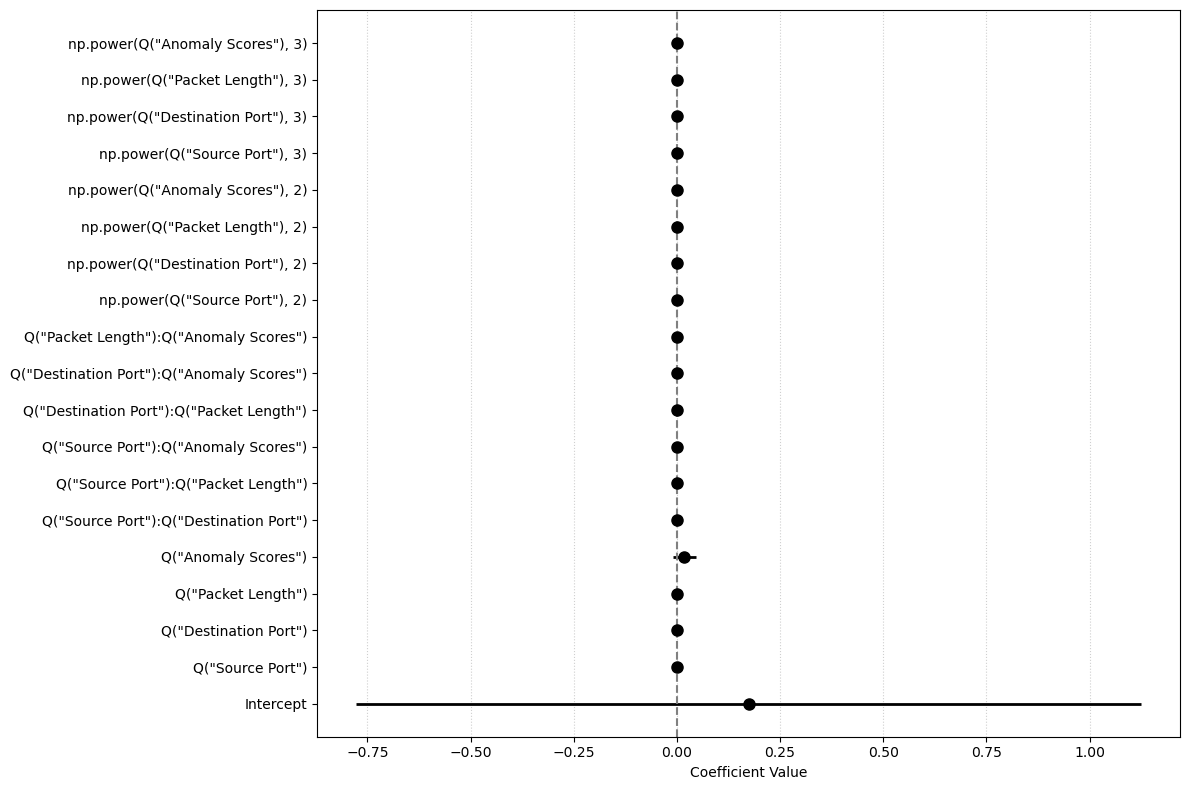

In [94]:
my_coefplot(model_06)

### Model 07: Continuous Inputs w/ Linear Main Effect & Pair-Wise Interactions Quartic

In [95]:
model_07 = smf.logit(formula=formula_list[7], 
                     data=df_clean). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.689768
         Iterations 4


In [96]:
model_07.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Q("Malware Event")   No. Observations:                 2451
Model:                          Logit   Df Residuals:                     2428
Method:                           MLE   Df Model:                           22
Date:                Sat, 30 Aug 2025   Pseudo R-squ.:                0.004812
Time:                        11:07:16   Log-Likelihood:                -1690.6
converged:                       True   LL-Null:                       -1698.8
Covariance Type:            nonrobust   LLR p-value:                    0.7981
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.3572      0.570      0.626      0.531      -0.761       1.475
Q("Source Port")                          -3.539e-05   2.48e-05     -1.426      0.154    -8.4e-05    1.32e-05
Q("Destination Port")                     -2.322e-05   2.56e-05     -0.908      0.364   -7.33e-05    2.69e-05
Q("Packet Length")                           -0.0004      0.003     -0.156      0.876      -0.006       0.005
Q("Anomaly Scores")                          -0.0027      0.028     -0.093      0.926      -0.058       0.053
Q("Source Port"):Q("Destination Port")      1.89e-10   1.19e-10      1.593      0.111   -4.35e-11    4.22e-10
Q("Source Port"):Q("Packet Length")         4.25e-10   5.21e-09      0.082      0.935   -9.79e-09    1.06e-08
Q("Source Port"):Q("Anomaly Scores")        2.97e-09   7.55e-08      0.039      0.969   -1.45e-07    1.51e-07
Q("Destination Port"):Q("Packet Length")   7.936e-10   5.26e-09      0.151      0.880   -9.52e-09    1.11e-08
Q("Destination Port"):Q("Anomaly Scores")  5.485e-08   7.66e-08      0.716      0.474   -9.53e-08    2.05e-07
Q("Packet Length"):Q("Anomaly Scores")    -6.135e-06    3.4e-06     -1.803      0.071   -1.28e-05    5.33e-07
np.power(Q("Source Port"), 2)              1.047e-09   8.71e-10      1.201      0.230   -6.61e-10    2.75e-09
np.power(Q("Destination Port"), 2)         4.175e-10   8.91e-10      0.468      0.639   -1.33e-09    2.16e-09
np.power(Q("Packet Length"), 2)            1.637e-06   6.77e-06      0.242      0.809   -1.16e-05    1.49e-05
np.power(Q("Anomaly Scores"), 2)              0.0006      0.001      0.544      0.587      -0.002       0.003
np.power(Q("Source Port"), 3)             -9.831e-15   8.85e-15     -1.111      0.267   -2.72e-14    7.51e-15
np.power(Q("Destination Port"), 3)        -3.242e-15   9.15e-15     -0.354      0.723   -2.12e-14    1.47e-14
np.power(Q("Packet Length"), 3)           -1.831e-09   6.37e-09     -0.287      0.774   -1.43e-08    1.07e-08
np.power(Q("Anomaly Scores"), 3)          -1.295e-05   1.74e-05     -0.745      0.456    -4.7e-05    2.11e-05
np.power(Q("Source Port"), 4)              1.335e-20   1.34e-20      0.994      0.320    -1.3e-20    3.97e-20
np.power(Q("Destination Port"), 4)         2.587e-21   1.39e-20      0.187      0.852   -2.46e-20    2.97e-20
np.power(Q("Packet Length"), 4)            7.204e-13   2.02e-12      0.356      0.722   -3.24e-12    4.68e-12
np.power(Q("Anomaly Scores"), 4)           7.516e-08   8.66e-08      0.868      0.386   -9.46e-08    2.45e-07
=============================================================================================================
"""

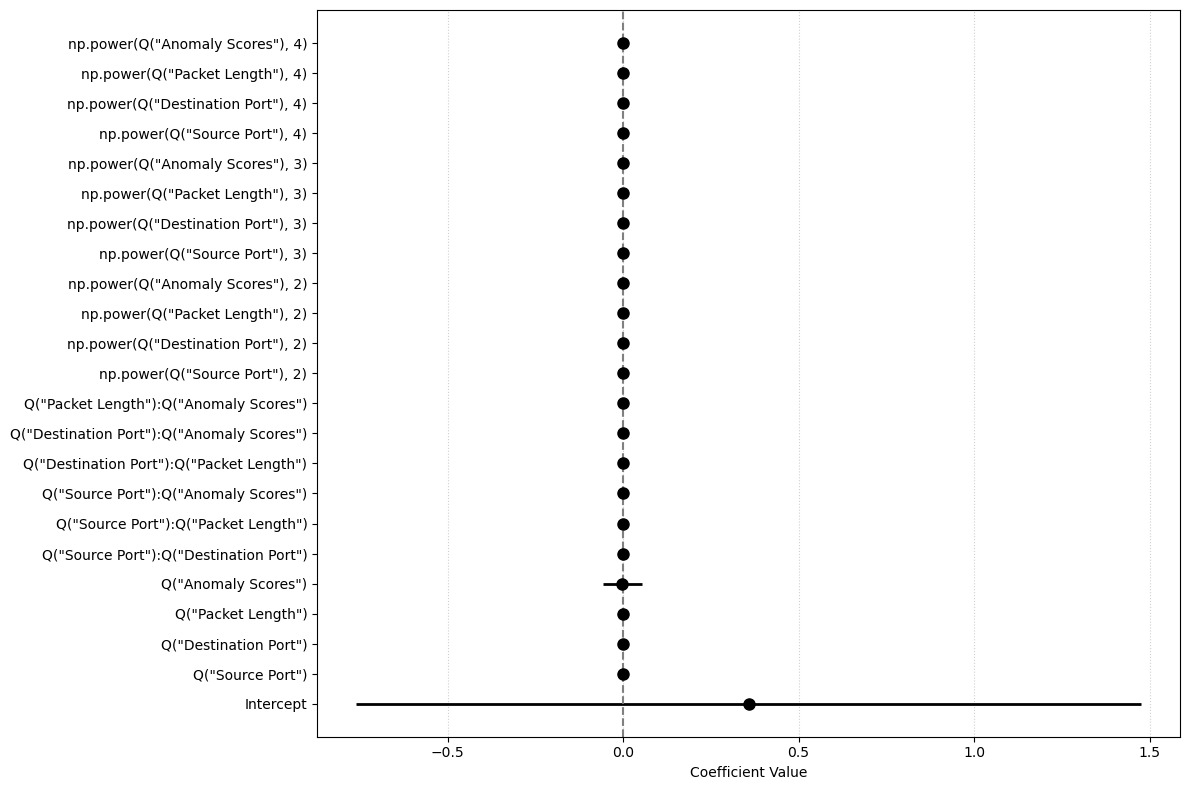

In [97]:
my_coefplot(model_07)

### Model 08: Pairwise Interactions Among Key Categorical Features

In [98]:
model_08 = smf.logit(formula=formula_list[8], 
                     data=df_clean). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.688747
         Iterations 4


In [99]:
model_08.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Q("Malware Event")   No. Observations:                 2451
Model:                          Logit   Df Residuals:                     2432
Method:                           MLE   Df Model:                           18
Date:                Sat, 30 Aug 2025   Pseudo R-squ.:                0.006285
Time:                        11:07:16   Log-Likelihood:                -1688.1
converged:                       True   LL-Null:                       -1698.8
Covariance Type:            nonrobust   LLR p-value:                    0.2620
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         0.2708      0.175      1.545      0.122      -0.073       0.614
C(Q("Protocol"))[T.TCP]                                          -0.0874      0.141     -0.620      0.535      -0.363       0.189
C(Q("Protocol"))[T.UDP]                                          -0.0150      0.137     -0.109      0.913      -0.284       0.254
C(Q("Packet Type"))[T.Data]                                       0.1293      0.142      0.911      0.362      -0.149       0.407
C(Q("Traffic Type"))[T.FTP]                                      -0.4196      0.174     -2.407      0.016      -0.761      -0.078
C(Q("Traffic Type"))[T.HTTP]                                     -0.5450      0.176     -3.099      0.002      -0.890      -0.200
C(Q("Attack Type"))[T.Intrusion]                                 -0.1369      0.182     -0.752      0.452      -0.494       0.220
C(Q("Attack Type"))[T.Malware]                                   -0.1598      0.176     -0.906      0.365      -0.505       0.186
C(Q("Severity Level"))[T.Low]                                    -0.0103      0.100     -0.104      0.917      -0.206       0.185
C(Q("Severity Level"))[T.Medium]                                 -0.0667      0.099     -0.677      0.499      -0.260       0.126
C(Q("Action Taken"))[T.Ignored]                                   0.0999      0.099      1.007      0.314      -0.095       0.294
C(Q("Action Taken"))[T.Logged]                                    0.0432      0.099      0.436      0.663      -0.151       0.237
C(Q("Log Source"))[T.Server]                                      0.0475      0.081      0.584      0.559      -0.112       0.207
C(Q("Protocol"))[T.TCP]:C(Q("Packet Type"))[T.Data]              -0.1226      0.201     -0.611      0.541      -0.516       0.271
C(Q("Protocol"))[T.UDP]:C(Q("Packet Type"))[T.Data]              -0.0615      0.199     -0.309      0.757      -0.452       0.329
C(Q("Traffic Type"))[T.FTP]:C(Q("Attack Type"))[T.Intrusion]      0.3928      0.248      1.585      0.113      -0.093       0.879
C(Q("Traffic Type"))[T.HTTP]:C(Q("Attack Type"))[T.Intrusion]     0.2930      0.249      1.175      0.240      -0.196       0.782
C(Q("Traffic Type"))[T.FTP]:C(Q("Attack Type"))[T.Malware]        0.1807      0.246      0.734      0.463      -0.302       0.663
C(Q("Traffic Type"))[T.HTTP]:C(Q("Attack Type"))[T.Malware]       0.3164      0.244      1.297      0.194      -0.162       0.794
=================================================================================================================================
"""

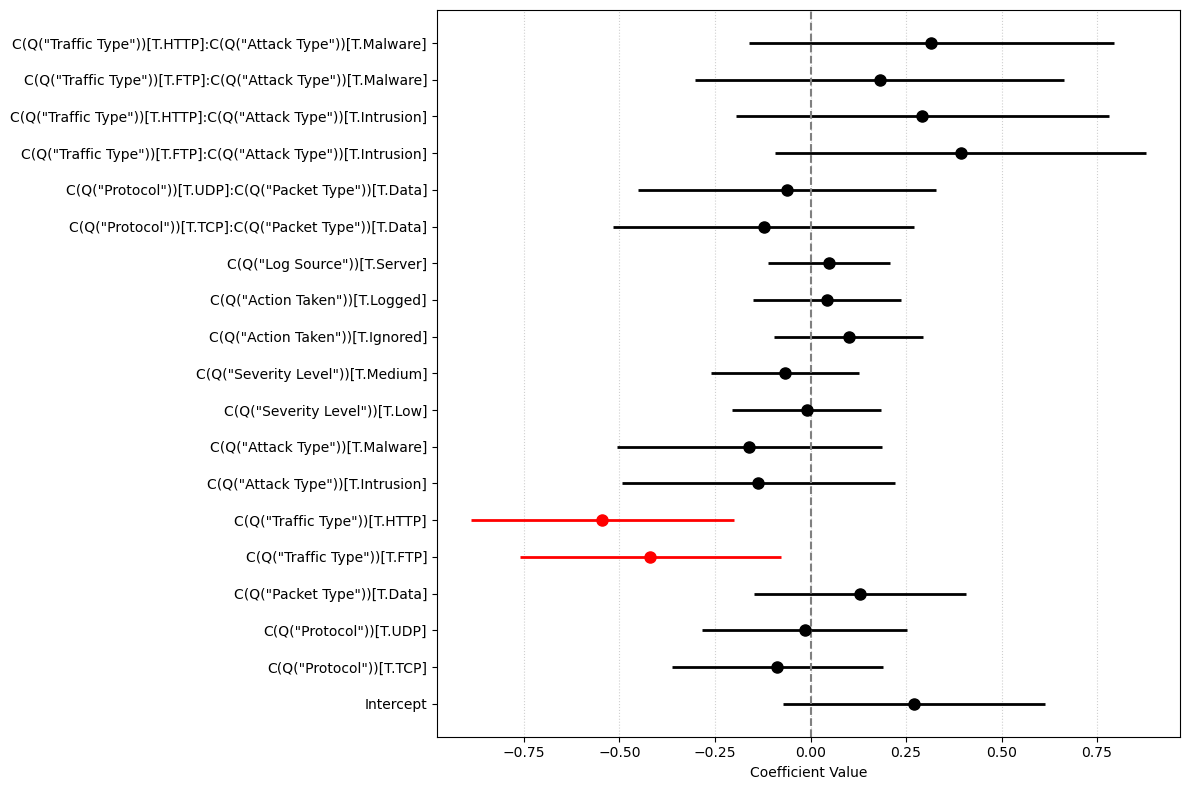

In [100]:
my_coefplot(model_08)

## Stratified K-Fold Cross-Validation

### Create 5-Fold Cross-Validation Object

In [101]:
kf = StratifiedKFold(n_splits=5, 
                     shuffle=True, 
                     random_state=42)

### Create Input & Output Variables

In [102]:
input_names = df_clean. \
              drop(columns=['Malware Event']). \
              copy(). \
              columns.to_list()

#### The `input_names` can have ALL variables included as the Patsy formula interface only includes variables explicitly mentioned in the formula string.

In [103]:
input_names

['Timestamp',
 'Source IP Address',
 'Destination IP Address',
 'Source Port',
 'Destination Port',
 'Protocol',
 'Packet Length',
 'Packet Type',
 'Traffic Type',
 'Payload Data',
 'Malware Indicators',
 'Anomaly Scores',
 'Alerts/Warnings',
 'Attack Type',
 'Attack Signature',
 'Action Taken',
 'Severity Level',
 'User Information',
 'Device Information',
 'Network Segment',
 'Geo-location Data',
 'Proxy Information',
 'Firewall Logs',
 'IDS/IPS Alerts',
 'Log Source']

In [104]:
output_name = 'Malware Event'

In [105]:
output_name

'Malware Event'

### Execute Cross-Validation

In [106]:
results_list = []

for model in range(len(formula_list)):
    print( '-- Formula ID %d --' % model)
    try:
        results_list.append(train_and_test_logistic_with_cv(model, 
                                                            formula_list[model], 
                                                            df=df_clean, 
                                                            input_names=input_names, 
                                                            output_name=output_name, 
                                                            cv=kf))
    except Exception as e:
        print(f'!!! Formula ID {model} could NOT fit: {str(e)} !!!')

-- Formula ID 0 --
-- Formula ID 1 --
-- Formula ID 2 --
-- Formula ID 3 --
-- Formula ID 4 --
-- Formula ID 5 --
-- Formula ID 6 --
-- Formula ID 7 --
-- Formula ID 8 --


### Review Cross-Validation Results

In [107]:
cv_results = pd.concat(results_list, ignore_index=True)

In [108]:
cv_results

,Accuracy,from_set,fold_id,model_name,model_formula,num_coefs,threshold
0,0.504592,training,1,0,"Q(""Malware Event"") ~ 1",1,0.5
1,0.504335,training,2,0,"Q(""Malware Event"") ~ 1",1,0.5
2,0.504844,training,3,0,"Q(""Malware Event"") ~ 1",1,0.5
3,0.504844,training,4,0,"Q(""Malware Event"") ~ 1",1,0.5
4,0.504844,training,5,0,"Q(""Malware Event"") ~ 1",1,0.5
...,...,...,...,...,...,...,...
85,0.507128,testing,1,8,"Q(""Malware Event"") ~ C(Q(""Protocol"")) * C(Q(""P...",19,0.5
86,0.538776,testing,2,8,"Q(""Malware Event"") ~ C(Q(""Protocol"")) * C(Q(""P...",19,0.5
87,0.489796,testing,3,8,"Q(""Malware Event"") ~ C(Q(""Protocol"")) * C(Q(""P...",19,0.5
88,0.483673,testing,4,8,"Q(""Malware Event"") ~ C(Q(""Protocol"")) * C(Q(""P...",19,0.5


In [109]:
cv_results.loc[cv_results.from_set == 'testing', :]. \
               groupby('model_name'). \
               agg({'Accuracy': 'mean', 
                    'num_coefs': 'first'}). \
                    sort_values('Accuracy', 
                                ascending=False)

,Accuracy,num_coefs
model_name,,
1,0.514068,16
5,0.513680,26
8,0.507956,19
3,0.505512,20
7,0.505118,23
0,0.504692,1
4,0.496957,15
6,0.490830,19
2,0.483481,5


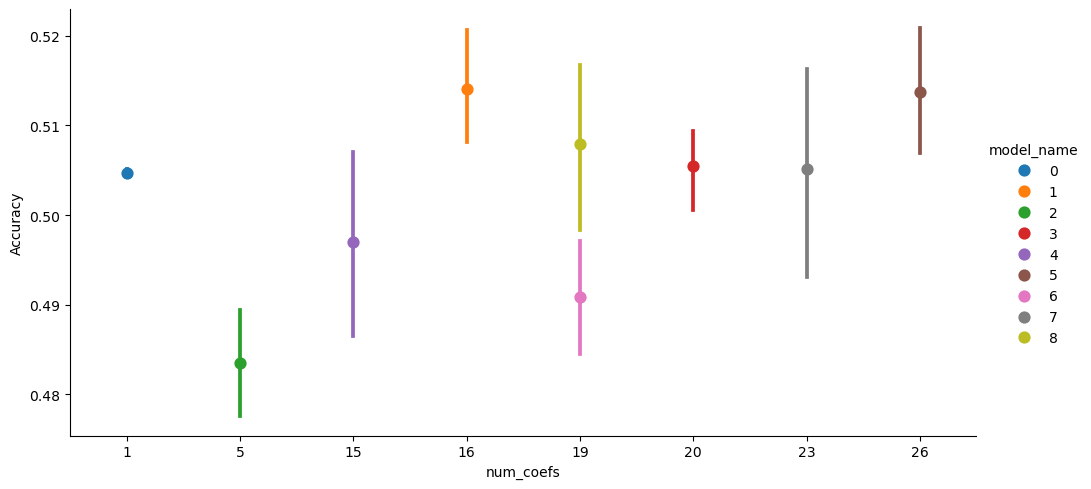

In [110]:
sns.catplot(data=cv_results.loc[cv_results.from_set == 'testing', :],
            x='num_coefs', 
            y='Accuracy', 
            kind='point', 
            hue='model_name',
            linestyle='none',
            errorbar=('ci', 68),
            palette='tab10',
            aspect=2)
plt.show()

In [111]:
formula_list[1]

'Q("Malware Event") ~ C(Q("Protocol")) + C(Q("Packet Type")) + C(Q("Traffic Type")) + C(Q("Alerts/Warnings")) + C(Q("Attack Type")) + C(Q("Attack Signature")) + C(Q("Action Taken")) + C(Q("Severity Level")) + C(Q("Network Segment")) + C(Q("Firewall Logs")) + C(Q("IDS/IPS Alerts")) + C(Q("Log Source"))'

## Model Selection

In [112]:
best_model = smf.logit(formula=formula_list[1], 
                       data=df_clean). \
                       fit()

Optimization terminated successfully.
         Current function value: 0.688893
         Iterations 4


In [113]:
best_model.pvalues < 0.05

Intercept                                      False
C(Q("Protocol"))[T.TCP]                        False
C(Q("Protocol"))[T.UDP]                        False
C(Q("Packet Type"))[T.Data]                    False
C(Q("Traffic Type"))[T.FTP]                     True
C(Q("Traffic Type"))[T.HTTP]                    True
C(Q("Attack Type"))[T.Intrusion]               False
C(Q("Attack Type"))[T.Malware]                 False
C(Q("Attack Signature"))[T.Known Pattern B]    False
C(Q("Action Taken"))[T.Ignored]                False
C(Q("Action Taken"))[T.Logged]                 False
C(Q("Severity Level"))[T.Low]                  False
C(Q("Severity Level"))[T.Medium]               False
C(Q("Network Segment"))[T.Segment B]           False
C(Q("Network Segment"))[T.Segment C]           False
C(Q("Log Source"))[T.Server]                   False
dtype: bool

In [114]:
np.abs(best_model. \
       params[best_model.pvalues < 0.05]). \
       sort_values(ascending=False)

C(Q("Traffic Type"))[T.HTTP]    0.335515
C(Q("Traffic Type"))[T.FTP]     0.225735
dtype: float64

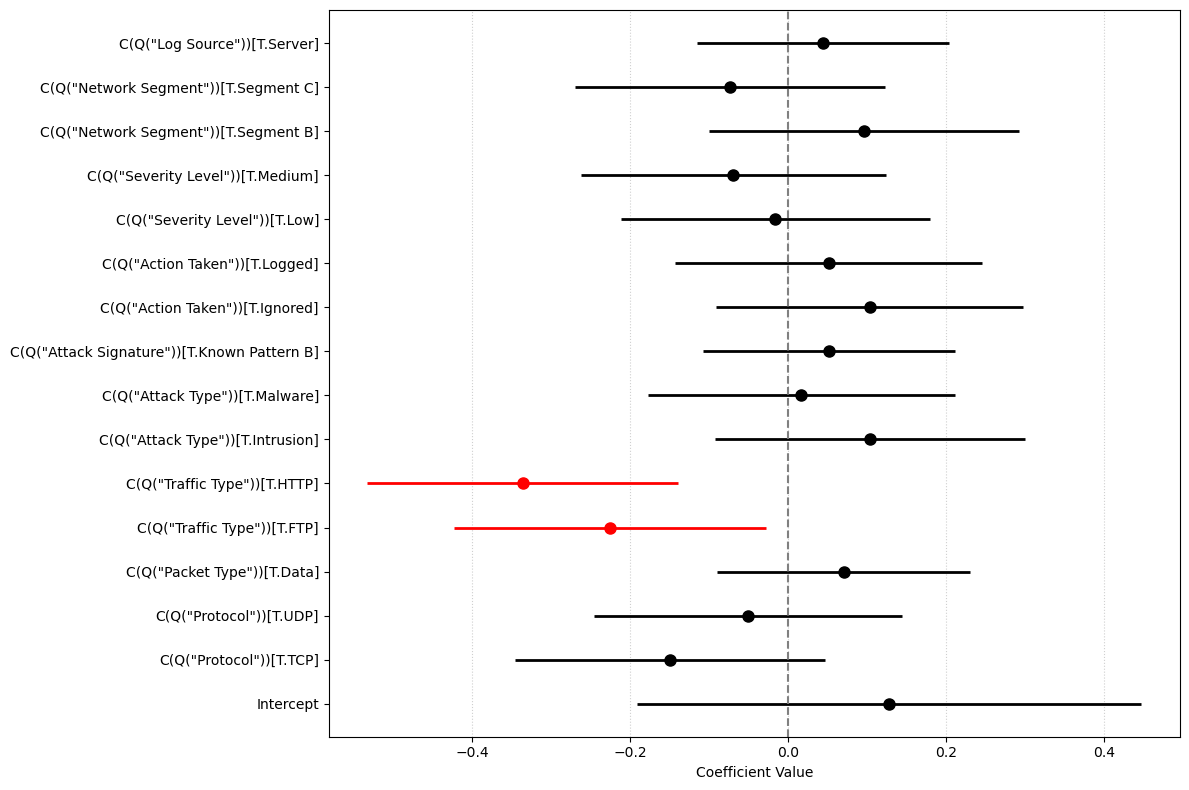

In [115]:
my_coefplot(best_model)

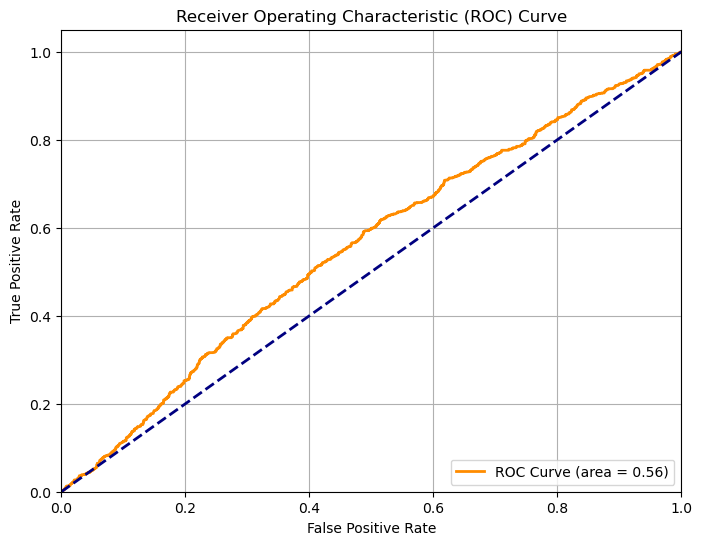

In [116]:
y_true = df_clean['Malware Event']
y_prob = best_model.predict(df_clean)
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, 
         tpr, 
         color='darkorange', 
         lw=2, 
         label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], 
         [0, 1], 
         color='navy', 
         lw=2, 
         linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()